In [1]:
#Extracts data from CSV file
#Creates paramterized feature map and ansatz
#Utilizes quantum neural network for training and SPSA for optimization

from cProfile import label
from turtle import color
import numpy as np
import math
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit, assemble
from qiskit.circuit import ParameterVector, Parameter
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, TwoLocal
#from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sympy import rotations

In [2]:
data_file = open("SomeData.csv")                    #Reads data from csv file
data_array = np.loadtxt(data_file, delimiter=",")   #Creates array from sample data
sample_size, nb_features = data_array.shape         #Gathers sample size and feature size values from data array


#Need some sort of a classification in place, so we can "classifiy". Update this code to create classification for our data.
labels = [0, 1]
y = (data_array[:,1] > 0.5).astype(int)     #Assigns label 1 or 0, depending on data value being larger than 0.5 or not.
#print(y)

x_train, x_test, y_train, y_test = train_test_split(data_array, y, test_size=0.2)   #Splits data_array 80:20 between train and test
print(x_test)
print(y_test)

[[0.03732483 0.38627519]
 [0.65519238 0.99362903]
 [0.10597876 0.8311643 ]
 [0.23238789 0.12613017]
 [0.96990231 0.68546746]
 [0.4234473  0.93395587]
 [0.88289985 0.75412468]
 [0.72152211 0.5968605 ]
 [0.45030083 0.40277648]
 [0.11899276 0.77525695]
 [0.17125782 0.59777718]
 [0.29611713 0.51366026]
 [0.04476299 0.15886721]
 [0.59214803 0.17822142]
 [0.5279577  0.78843944]
 [0.89572022 0.04048163]
 [0.81996565 0.04054952]
 [0.95789384 0.39722122]
 [0.76864477 0.89453389]
 [0.0646968  0.68828218]]
[0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1]


In [3]:
#Preps the backend and the quantum instance
sim = Aer.get_backend('aer_simulator')
shots = 8092
qinst = QuantumInstance(sim, shots)

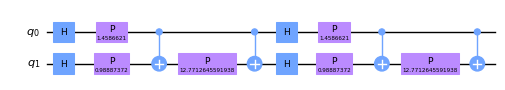

In [4]:
#Puts together the feature map
map_z = ZZFeatureMap(feature_dimension=nb_features, reps=2, entanglement='linear')
map_z.assign_parameters({k:v for (k,v) in zip(map_z.parameters, x_train[0])}).decompose().draw('mpl', scale=0.7)

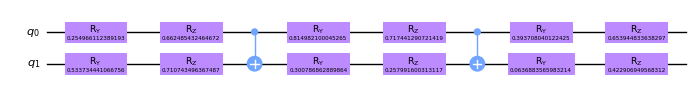

In [5]:
#Puts together the ansatz
def get_two_locals(nb_features, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=nb_features, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz= get_two_locals(nb_features, ['ry', 'rz'], 2, 'linear')
#ansatz.decompose().draw('mpl', scale=0.7)
weights = np.random.random(len(ansatz.parameters))  #Assigns weights, it oftens initiated as random numbers
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=0.7)

In [6]:
#Quantum Neural Network training happens here
var_circuit = map_z.compose(ansatz)
var_circuit.draw('mpl')
#plt.show()

def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

num_classes = 2
qnn = CircuitQNN(circuit = var_circuit,
                input_params=map_z.parameters,
                weight_params=ansatz.parameters,
                interpret=one_qubit_binary,
                output_shape=num_classes,
                gradient=None,
                quantum_instance=qinst)

output = qnn.forward(x_train[0], weights)   #Forward pass
#print(output.shape)

_, update = qnn.backward(x_train[0], weights)   #Backward pass

In [7]:
#Training Section

#One hot encoding. If you want to know about this encoding, pls google. It is not an arbitrary encoding method, it is used a lot in ML
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [8]:
#This function can create a checkpoint in case we hit the optimal point before the maximum iteration is reached. It is unused right now.
def callback(nfev, params, fval, stepsize, accepted=None):
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [9]:
#Neural network classification
n_iterations = 50
spsa_opt = SPSA(maxiter=n_iterations, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                            loss=CrossEntropyLoss(),
                            one_hot=True,
                            optimizer=spsa_opt,
                            initial_point=initial_point)

x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train])     #Normalizes data set. Why is it necessary? We may want to ask.

vqc = vqc.fit(x_train_norm, y_train_1h)

3 - 75.69223617287838
6 - 71.26219875531606
9 - 64.5543367555183
12 - 64.42708735486977
15 - 62.324883993779984
18 - 61.66659506792809
21 - 61.49048298032925
24 - 61.47325488147602
27 - 61.28664360127314
30 - 61.11788876103023
33 - 61.16343717494772
36 - 61.18293688078861
39 - 60.99020960595246
42 - 61.269252328233705
45 - 60.68488741190165
48 - 61.03288759917053
51 - 60.69007358804093
54 - 60.565870129265534
57 - 60.51745161212631
60 - 60.776097478584646
63 - 60.59982403235446
66 - 60.760218980991176
69 - 60.44895973902883
72 - 60.77721579096236
75 - 60.98727305161756
78 - 60.50404840709241
81 - 60.49177105870633
84 - 60.7120438031738
87 - 60.41572071555263
90 - 60.87129057929233
93 - 60.52217875766495
96 - 60.59567562201058
99 - 60.554843016442845
102 - 60.496561355964964
105 - 60.66507872859885
108 - 60.45080086776622
111 - 60.411260227703174
114 - 60.368446043831334
117 - 60.497211494084425
120 - 60.48645301029107
123 - 60.173788811868945
126 - 60.31423158345968
129 - 60.4305186656

In [10]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the training set: {score_train}')
print(f'Score on the test set {score_test}')

Score on the training set: 0.6375
Score on the test set 0.65
